<a href="https://colab.research.google.com/github/Alim20022004/FederatedLearning/blob/main/Federated_Learning_with_HE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install medmnist
!pip -q install flwr[simulation]
!pip -q install tenseal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 38.5 MB/s eta 0:00:00

In [ ]:
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from medmnist import PathMNIST
import flwr as fl
from typing import Dict, List, Tuple
from flwr.common import Context, Metrics
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import log
from flwr.common import Scalar,NDArrays
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from torchvision.models import resnet18,ResNet18_Weights,efficientnet_b0, EfficientNet_B0_Weights
import tenseal as ts
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Flower {fl.__version__}")

Flower 1.18.0


# **2.TenSEAL Context Initialization and CU Library Functions**

In [ ]:
# Cell 2: TenSEAL Context Initialization and CU Library Functions

# Set TenSEAL parameters
poly_modulus_degree = 8192 # High security, adjust if performance is a concern
coeff_mod_bit_sizes = [60, 40, 40, 60]  # Supports multiple operations
global_scale = 2**40  # Precision scaling

# Create a TenSEAL context with CKKS scheme
ts_context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=poly_modulus_degree,
    coeff_mod_bit_sizes=coeff_mod_bit_sizes
)
ts_context.generate_galois_keys()
ts_context.global_scale = global_scale

# Serialize contexts:
# The secret_context contains the private key (only for clients)
secret_context = ts_context.serialize(save_secret_key=True)
# The public_context does not include the private key (for server use)
public_context = ts_context.serialize()

# --- Begin custom "cu" library functions ---


def deserialization(param_list: list, context: ts.Context) -> list:
    deslist=[]
    for param in param_list:
        parambytes =param.tobytes()
        deserialized_params= ts.ckks_vector_from(context, parambytes)
        deslist.append(deserialized_params)
    return deslist
# Global variable to hold the original shapes of model parameters.
# This will be set once when the model is initialized.
PARAMETER_SHAPES = None

def plain(encrypted_vectors: list, context: ts.Context) -> list:

    global PARAMETER_SHAPES
    decrypted_list = []
    for vec, shape in zip(encrypted_vectors, PARAMETER_SHAPES):
        flat = np.array(vec.decrypt())
        decrypted_list.append(flat.reshape(shape))
    return decrypted_list

def cipher(ndarrays: list, context: ts.Context) -> list:
    encrypted_params = []
    for arr in ndarrays:
        flat_list = arr.flatten().tolist()
        ckks_vec = ts.ckks_vector(context, flat_list)
        encrypted_params.append(ckks_vec)
    return encrypted_params
def serialization(ckks_vec:list)->list:
    enc_par_ser=[]
    for ckk_vec in ckks_vec:
      serialized_ckks = ckk_vec.serialize()
      np_serialized = np.frombuffer(serialized_ckks, dtype=np.uint8)
      enc_par_ser.append(np_serialized)
    return enc_par_ser

def aggregate(encrypted_params_groups: list, context: ts.Context) -> list:

    if not encrypted_params_groups:
        return []

    num_params = len(encrypted_params_groups[0][0])
    total_weight = sum(weight for (_, weight) in encrypted_params_groups)
    aggregated = []

    for param_idx in range(num_params):
        agg_vec = None
        for (encrypted_params, weight) in encrypted_params_groups:
            # Deserialize encrypted parameter
            np_encrypted = encrypted_params[param_idx]
            encrypted_bytes = np_encrypted.tobytes()
            ckks_vec = ts.ckks_vector_from(context, encrypted_bytes)
            # Apply weight and accumulate
            weighted_vec = ckks_vec * weight

            if agg_vec is None:
                agg_vec = weighted_vec
            else:
                agg_vec += weighted_vec
        agg_vec *= (1.0 / total_weight)
        serialized_agg = agg_vec.serialize()
        np_serialized = np.frombuffer(serialized_agg, dtype=np.uint8)
        aggregated.append(np_serialized)
    return aggregated





# **3.Model, Training, and Evaluation Functions**

In [ ]:
# Cell 3: Model, Training, and Evaluation Functions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 9

# Initialize EfficientNet-B0 and adjust for the number of classes
modeleff = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
modeleff.classifier[1] = nn.Linear(modeleff.classifier[1].in_features, num_classes)
modelefficient = modeleff.to(device)


def train_epoch(model, train_loader):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.squeeze().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    return train_loss, train_acc

def validate(model, val_loader):
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.squeeze().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

def evaluate_model(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    test_loss = 0.0
    all_preds = []
    all_labels = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.squeeze().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    return test_loss, test_acc, np.array(all_preds), np.array(all_labels)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s] 


# **4.Data Loading, Partitioning, and Visualization Functions**

In [ ]:
import time
# Cell 4: Data Loading, Partitioning, and Visualization Functions

BATCH_SIZE = 64
NUM_CLIENTS = 5

def load_full_datasets():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset = PathMNIST(split='train', transform=train_transform, download=True)
    val_dataset = PathMNIST(split='val', transform=test_transform, download=True)
    return train_dataset, val_dataset

def load_test_dataset():
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    test_dataset = PathMNIST(split='test', transform=test_transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    return test_loader

def partition_dataset(dataset, num_partitions: int):
    indices = np.random.permutation(len(dataset))
    partitions_indices = np.array_split(indices, num_partitions)
    subsets = [Subset(dataset, idx) for idx in partitions_indices]
    return subsets

# --- Perform data loading and partitioning ONCE globally ---
print("Loading and partitioning datasets globally...")
start_time_data_prep = time.time()

# 1. Load full datasets once
FULL_TRAIN_DATASET, FULL_VAL_DATASET = load_full_datasets()
print(f"Full train dataset size: {len(FULL_TRAIN_DATASET)}")
print(f"Full val dataset size: {len(FULL_VAL_DATASET)}")
# 2. Partition them once
# Choose your partitioning strategy (e.g., Non-IID)
TRAIN_PARTITIONS = partition_dataset(FULL_TRAIN_DATASET, NUM_CLIENTS)
print(f"Train partitions: {len(TRAIN_PARTITIONS)}")

VAL_PARTITIONS = partition_dataset(FULL_VAL_DATASET, NUM_CLIENTS)
print(f"Val partitions: {len(VAL_PARTITIONS)}")
# Or for IID:
# TRAIN_PARTITIONS = partition_dataset(FULL_TRAIN_DATASET, NUM_CLIENTS)
# VAL_PARTITIONS = partition_dataset(FULL_VAL_DATASET, NUM_CLIENTS)

end_time_data_prep = time.time()
print(f"Data loaded and partitioned for {NUM_CLIENTS} clients in {end_time_data_prep - start_time_data_prep:.2f} seconds.")




Loading and partitioning datasets globally...


100%|██████████| 206M/206M [00:10<00:00, 19.4MB/s]


Full train dataset size: 89996
Full val dataset size: 10004
Train partitions: 5
Val partitions: 5
Data loaded and partitioned for 5 clients in 14.23 seconds.


In [ ]:
def load_client_dataloaders(partition_id: int):
    """
    Creates DataLoaders for a specific client using pre-partitioned global data.
    """
    if not (0 <= partition_id < NUM_CLIENTS):
        raise ValueError(f"Partition ID {partition_id} is out of bounds for {NUM_CLIENTS} clients.")

    client_train_subset = TRAIN_PARTITIONS[partition_id]

    train_loader = DataLoader(client_train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True if device.type == "cuda" else False)
    return train_loader

# **5.Utility Functions for Model Parameters**

In [ ]:
# Cell 5: Utility Functions for Model Parameters
from collections import OrderedDict

def get_parameters(model) -> list:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

def set_parameters(model, parameters: list):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict)

# Global variable to store parameter shapes.
# Call this once after model initialization.
def store_parameter_shapes(model):
    global PARAMETER_SHAPES
    PARAMETER_SHAPES = [arr.shape for arr in get_parameters(model)]

store_parameter_shapes(modelefficient)


# **6.Flower Client Class with Homomorphic Encryption Integration**

In [ ]:
# Cell 6: Flower Client Class with Homomorphic Encryption Integration
import time
class FlowerClient(fl.client.Client):
    def __init__(self, partition_id, model, train_loader, eval_loader):
        self.partition_id = partition_id
        self.model = model
        self.train_loader = train_loader
        self.eval_loader = eval_loader

    def fit(self, ins):
        timings = {}
        print(f"[Client {self.partition_id}] fit")
        # --- Decrypt the received global parameters ---
        #-----------------------------------------------------------------------------------------
        print("start deserialization")
        start = time.time()
        deserialized_params = parameters_to_ndarrays(ins.parameters)
        # Convert numpy arrays to bytes
        private_ts_context = ts.context_from(secret_context)
        encrypted_vectors = deserialization(deserialized_params, private_ts_context)
        timings['deserialization'] = time.time() - start
        print("End deserialization")
        #-----------------------------------------------------------------------------------------
        # Decrypt CKKS vectors to obtain plaintext parameters (flat arrays)
        print("start decryption")
        start = time.time()
        plaintext_params = plain(encrypted_vectors, private_ts_context)
        timings['decryption'] = time.time() - start
        print("End Decryption ")
        #-----------------------------------------------------------------------------------------
        set_parameters(self.model, plaintext_params)
        print("model loaded")
        # --- Perform local training ---
        print("start training")
        start = time.time()
        train_loss, train_acc = train_epoch(self.model, self.train_loader)
        print(f"Train accuracy : {train_acc}| Train loss :{train_loss}")
        timings['training'] = time.time() - start
        print(f"client{self.partition_id} completed training.")
        #-----------------------------------------------------------------------------------------
        # --- Encrypt updated parameters to send back ---
        updated_params = get_parameters(self.model)
        print(f"Encryption ...")
        start = time.time()
        public_ts_context = ts.context_from(public_context)
        encrypted_updated = cipher(updated_params, public_ts_context)
        timings['encryption'] = time.time() - start
        print(f"Encryption complete")
        #-----------------------------------------------------------------------------------------
        print(f"serialization")
        start = time.time()
        ser_encrypted_updated=serialization(encrypted_updated)
        parameters_encrypted = ndarrays_to_parameters(ser_encrypted_updated)
        timings['serialization'] = time.time() - start
        print(f"[Client {self.partition_id}] Timing breakdown: {timings}")

        status = Status(code=Code.OK, message="Success")
        return fl.common.FitRes(
            status=status,
            parameters=parameters_encrypted,
            num_examples=len(self.train_loader.dataset),

            metrics = {"deserialization": timings["deserialization"],
                        "decryption": timings["decryption"],
                        "training": timings["training"],
                        "encryption": timings["encryption"],
                        "serialization":timings['serialization']}

        )

    def get_parameters(self, ins):
        # Encrypt current model parameters for transmission
        current_params = get_parameters(self.model)
        public_ts_context = ts.context_from(public_context)
        encrypted_current = cipher(current_params, public_ts_context)
        return fl.common.GetParametersRes(
            status=Status(code=Code.OK, message="Success"),
            parameters=ndarrays_to_parameters(encrypted_current)
        )

    def evaluate(self, ins):
        print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")
        deserialized_params = parameters_to_ndarrays(ins.parameters)
        private_ts_context = ts.context_from(secret_context)
        encrypted_vectors = deserialization(deserialized_params, private_ts_context)
        plaintext_params = plain(encrypted_vectors, private_ts_context)
        set_parameters(self.model, plaintext_params)
        val_loss, val_acc = validate(self.model, self.eval_loader)
        print(f"Loss : {val_loss:.4f} | Accuracy: {val_acc :.2f} %")
        return fl.common.EvaluateRes(
            status=Status(code=Code.OK, message="Success"),
            loss=float(val_loss),
            num_examples=len(self.eval_loader.dataset),
            metrics={"Accuracy": float(val_acc)}
        )

def client_fn(context: Context) -> fl.client.Client:
    partition_id = context.node_config["partition-id"]
    train_loader = load_client_dataloaders(partition_id)
    print(f"Client {partition_id} initialized. Train samples: {len(train_loader.dataset)}")
    test_loader = load_test_dataset()
    return FlowerClient(partition_id, modelefficient, train_loader, test_loader)

client_app = fl.client.ClientApp(client_fn=client_fn)

# **8.Custom FedAvg Strategy with Encrypted Aggregation**

In [ ]:
# Cell 7: Custom FedAvg Strategy with Encrypted Aggregation
global round_times, aggregation_times
round_times = []  # Reset timing data for each simulation
aggregation_times = []  # To store aggregation-specific timing data
class FedAvgFullHe(FedAvg):
    def configure_fit(self, server_round, parameters, client_manager):
        global round_times, aggregation_times
        self.round_start_time = time.time()
        return super().configure_fit(server_round, parameters, client_manager)

    def aggregate_fit(self, server_round, results, failures):
        if not results:
            return None, {}
        if not self.accept_failures and failures:
            return None, {}

        # Extract encrypted parameters and corresponding weights from client responses.
        global round_times, aggregation_times
        agg_start = time.time()
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        # Create a public TenSEAL context for aggregation operations.
        public_ts_context = ts.context_from(public_context)
        aggregated_weights = aggregate(weights_results, public_ts_context)
        aggregated_parameters = ndarrays_to_parameters(aggregated_weights)
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:
            print("Warning: No fit_metrics_aggregation_fn provided")
        agg_duration = time.time() - agg_start
        # Store aggregation time
        if not failures:
              aggregation_times.append((server_round, agg_duration))
              round_times.append((server_round, time.time() - self.round_start_time))
        # Aggregate metrics if a function is provided.
        return aggregated_parameters, metrics_aggregated


# **9.Client and Server Setup**

In [ ]:
# Cell 8: Client and Server Setup;
def weighted_average(metrics):
    total = sum(num_examples for num_examples, _ in metrics)
    val_acc = sum(num_examples * m["Accuracy"] for num_examples, m in metrics)
    return {"Accuracy": val_acc / total}

def avg_metrics(metrics):
    num_clients = len(metrics)
    if num_clients == 0:
        return {}

    aggregated = {
        "deserialization": sum(m["deserialization"] for _, m in metrics) / num_clients,
        "decryption": sum(m["decryption"] for _, m in metrics) / num_clients,
        "training": sum(m["training"] for _, m in metrics) / num_clients,
        "encryption": sum(m["encryption"] for _, m in metrics) / num_clients,
        "serialization": sum(m["serialization"] for _, m in metrics) / num_clients,
    }
    return aggregated


# Encrypt initial model parameters so that the first round is consistent
params = get_parameters(modelefficient)
public_ts_context = ts.context_from(public_context)
encrypted_initial_params = cipher(params, public_ts_context)
encrypted_initial_params_ser=serialization(encrypted_initial_params)
initial_parameters = ndarrays_to_parameters(encrypted_initial_params_ser)

def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAvgFullHe(
        fraction_fit=1,
        fraction_evaluate=0.1,
        min_available_clients=NUM_CLIENTS,
        min_evaluate_clients=1,
        fit_metrics_aggregation_fn=avg_metrics,
        #evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,  # Use encrypted initial parameters
        evaluate_metrics_aggregation_fn=weighted_average,
    )
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)

server_app = ServerApp(server_fn=server_fn)

# Backend configuration: adjust CPU/GPU resources per client if necessary
backend_config = {"client_resources": {"num_cpus": 2, "num_gpus": 1.0}}
if device.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 2, "num_gpus": 1.0}}




The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

#**10.Running the Simulation**

In [ ]:
# Run the federated learning simulation
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(pid=4114) 2025-05-13 12:47:31.975373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=4114) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=4114) E0000 00:00:1747140451.996376    4114 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=4114) E0000 00:00:1747140452.002880    4114 cuda_blas.

(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] fit
(ClientAppActor pid=4114) start deserialization
(ClientAppActor pid=4114) End deserialization
(ClientAppActor pid=4114) start decryption
(ClientAppActor pid=4114) End Decryption 
(ClientAppActor pid=4114) model loaded
(ClientAppActor pid=4114) start training
(ClientAppActor pid=4114) Train accuracy : 85.47222222222223| Train loss :0.4293339705055064
(ClientAppActor pid=4114) client0 completed training.
(ClientAppActor pid=4114) Encryption ...
(ClientAppActor pid=4114) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=4114) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=4114) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(ClientAppActor pid=4114) WARNING: The input does not fit in a s

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=4114) Client 1 initialized. Train samples: 17999
(ClientAppActor pid=4114) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4114) Loss : 0.3471 | Accuracy: 88.52 %
(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] fit
(ClientAppActor pid=4114) start deserialization
(ClientAppActor pid=4114) End deserialization
(ClientAppActor pid=4114) start decryption
(ClientAppActor pid=4114) End Decryption 
(ClientAppActor pid=4114) model loaded
(ClientAppActor pid=4114) start training
(ClientAppActor pid=4114) Train accuracy : 91.2| Train loss :0.270404548770649
(ClientAppActor pid=4114) client0 completed training.
(ClientAppActor pid=4114) Encryption ...
(ClientAppActor pid=4114) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=4114) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=4114) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(ClientAppActor pi

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=4114) Client 3 initialized. Train samples: 17999
(ClientAppActor pid=4114) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4114) Loss : 0.1600 | Accuracy: 94.54 %
(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] fit
(ClientAppActor pid=4114) start deserialization
(ClientAppActor pid=4114) End deserialization
(ClientAppActor pid=4114) start decryption
(ClientAppActor pid=4114) End Decryption 
(ClientAppActor pid=4114) model loaded
(ClientAppActor pid=4114) start training
(ClientAppActor pid=4114) Train accuracy : 92.62777777777778| Train loss :0.22432117828610518
(ClientAppActor pid=4114) client0 completed training.
(ClientAppActor pid=4114) Encryption ...
(ClientAppActor pid=4114) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=4114) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=4114) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=4114) Client 1 initialized. Train samples: 17999
(ClientAppActor pid=4114) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4114) Loss : 0.1500 | Accuracy: 94.87 %
(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] fit
(ClientAppActor pid=4114) start deserialization
(ClientAppActor pid=4114) End deserialization
(ClientAppActor pid=4114) start decryption
(ClientAppActor pid=4114) End Decryption 
(ClientAppActor pid=4114) model loaded
(ClientAppActor pid=4114) start training
(ClientAppActor pid=4114) Train accuracy : 93.7| Train loss :0.18964962838283667
(ClientAppActor pid=4114) client0 completed training.
(ClientAppActor pid=4114) Encryption ...
(ClientAppActor pid=4114) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=4114) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=4114) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(ClientAppActor 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=4114) Client 2 initialized. Train samples: 17999
(ClientAppActor pid=4114) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4114) Loss : 0.1476 | Accuracy: 94.62 %
(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] fit
(ClientAppActor pid=4114) start deserialization
(ClientAppActor pid=4114) End deserialization
(ClientAppActor pid=4114) start decryption
(ClientAppActor pid=4114) End Decryption 
(ClientAppActor pid=4114) model loaded
(ClientAppActor pid=4114) start training
(ClientAppActor pid=4114) Train accuracy : 94.51666666666667| Train loss :0.16737399890966026
(ClientAppActor pid=4114) client0 completed training.
(ClientAppActor pid=4114) Encryption ...
(ClientAppActor pid=4114) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=4114) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=4114) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=4114) Client 3 initialized. Train samples: 17999
(ClientAppActor pid=4114) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4114) Loss : 0.1587 | Accuracy: 94.55 %
(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] fit
(ClientAppActor pid=4114) start deserialization
(ClientAppActor pid=4114) End deserialization
(ClientAppActor pid=4114) start decryption
(ClientAppActor pid=4114) End Decryption 
(ClientAppActor pid=4114) model loaded
(ClientAppActor pid=4114) start training
(ClientAppActor pid=4114) Train accuracy : 95.12777777777778| Train loss :0.15130875028953855
(ClientAppActor pid=4114) client0 completed training.
(ClientAppActor pid=4114) Encryption ...
(ClientAppActor pid=4114) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=4114) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=4114) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=4114) Client 1 initialized. Train samples: 17999
(ClientAppActor pid=4114) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4114) Loss : 0.1768 | Accuracy: 94.90 %
(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] fit
(ClientAppActor pid=4114) start deserialization
(ClientAppActor pid=4114) End deserialization
(ClientAppActor pid=4114) start decryption
(ClientAppActor pid=4114) End Decryption 
(ClientAppActor pid=4114) model loaded
(ClientAppActor pid=4114) start training
(ClientAppActor pid=4114) Train accuracy : 95.30555555555556| Train loss :0.14652183098744945
(ClientAppActor pid=4114) client0 completed training.
(ClientAppActor pid=4114) Encryption ...
(ClientAppActor pid=4114) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=4114) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=4114) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=4114) Client 2 initialized. Train samples: 17999
(ClientAppActor pid=4114) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4114) Loss : 0.1791 | Accuracy: 94.16 %
(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] fit
(ClientAppActor pid=4114) start deserialization
(ClientAppActor pid=4114) End deserialization
(ClientAppActor pid=4114) start decryption
(ClientAppActor pid=4114) End Decryption 
(ClientAppActor pid=4114) model loaded
(ClientAppActor pid=4114) start training
(ClientAppActor pid=4114) Train accuracy : 95.78333333333333| Train loss :0.12988568934222275
(ClientAppActor pid=4114) client0 completed training.
(ClientAppActor pid=4114) Encryption ...
(ClientAppActor pid=4114) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=4114) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=4114) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4114) Loss : 0.1563 | Accuracy: 95.22 %
(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] fit
(ClientAppActor pid=4114) start deserialization
(ClientAppActor pid=4114) End deserialization
(ClientAppActor pid=4114) start decryption
(ClientAppActor pid=4114) End Decryption 
(ClientAppActor pid=4114) model loaded
(ClientAppActor pid=4114) start training
(ClientAppActor pid=4114) Train accuracy : 95.87777777777778| Train loss :0.12132469254895939
(ClientAppActor pid=4114) client0 completed training.
(ClientAppActor pid=4114) Encryption ...
(ClientAppActor pid=4114) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=4114) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=4114) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=4114) Client 2 initialized. Train samples: 17999
(ClientAppActor pid=4114) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4114) Loss : 0.1679 | Accuracy: 94.57 %
(ClientAppActor pid=4114) Client 0 initialized. Train samples: 18000
(ClientAppActor pid=4114) [Client 0] fit
(ClientAppActor pid=4114) start deserialization
(ClientAppActor pid=4114) End deserialization
(ClientAppActor pid=4114) start decryption
(ClientAppActor pid=4114) End Decryption 
(ClientAppActor pid=4114) model loaded
(ClientAppActor pid=4114) start training
(ClientAppActor pid=4114) Train accuracy : 96.32222222222222| Train loss :0.11784086572931063
(ClientAppActor pid=4114) client0 completed training.
(ClientAppActor pid=4114) Encryption ...
(ClientAppActor pid=4114) WARNING: The input does not fit in a single ciphertext, and some operations will be disabled.
(ClientAppActor pid=4114) The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
(ClientAppActor pid=4114) If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 5)


(ClientAppActor pid=4114) Client 3 initialized. Train samples: 17999
(ClientAppActor pid=4114) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 3799.01s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.3470967819469165
INFO :      		round 2: 0.15998371202597575
INFO :      		round 3: 0.14998198907195995
INFO :      		round 4: 0.14760277494458496
INFO :      		round 5: 0.15865718840365917
INFO :      		round 6: 0.17683774506491898
INFO :      		round 7: 0.17909824111358782
INFO :      		round 8: 0.156332606816483
INFO :      		round 9: 0.1678554793506597
INFO :      		round 10: 0.15797283642603893
INFO :      	History (metrics, distributed, fit):
INFO :      	{'decryption': [(1, 2.4137364864349364),
INFO :      	                (2, 0.9410467624664307),
INFO :      	                (3, 0.9396779537200928),
INFO :      	                (4, 0.915894889831543),
INFO :      	                (5, 0.9255888938903809),
INFO :      	                (6, 0.9462644577026367),
INFO :  

(ClientAppActor pid=4114) Loss : 0.1580 | Accuracy: 95.38 %


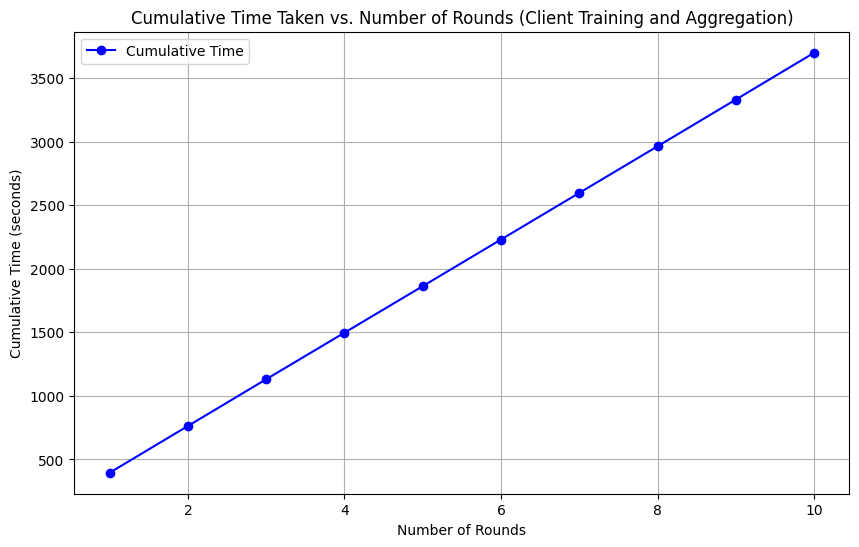

[(1, 395.89706206321716), (2, 367.51403546333313), (3, 367.68400859832764), (4, 365.8704512119293), (5, 365.96301531791687), (6, 366.85441970825195), (7, 366.60748052597046), (8, 366.66558480262756), (9, 367.4271287918091), (10, 368.01070165634155)]
Total time taken for 10 rounds (client training and aggregation): 3698.49 seconds
Average round duration: 369.85 seconds
[(1, 18.591727256774902), (2, 17.933279752731323), (3, 17.26260280609131), (4, 17.206749200820923), (5, 17.177032232284546), (6, 17.23075795173645), (7, 17.11463236808777), (8, 17.283828020095825), (9, 17.291036367416382), (10, 17.68042755126953)]
Average aggregation time: 17.48 seconds


In [ ]:
def plot_time_curve():

    global round_times ,aggregation_times

    if not round_times:
        print("No timing data collected during simulation.")
        return

    # Extract rounds and times
    rounds = [r for r, _ in round_times]
    times = [t for _, t in round_times]
    cumulative_times = np.cumsum(times)  # Compute cumulative time

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, cumulative_times, marker='o', linestyle='-', color='b', label='Cumulative Time')
    plt.xlabel('Number of Rounds')
    plt.ylabel('Cumulative Time (seconds)')
    plt.title('Cumulative Time Taken vs. Number of Rounds (Client Training and Aggregation)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Display total time
    print(round_times)
    total_time = cumulative_times[-1]
    print(f"Total time taken for {len(rounds)} rounds (client training and aggregation): {total_time:.2f} seconds")
    avg_duration = sum(duration for _, duration in round_times) / len(round_times)
    print(f"Average round duration: {avg_duration:.2f} seconds")
    print(aggregation_times)
    avg_aggregation_time = sum(duration for _, duration in aggregation_times) / len(aggregation_times)
    print(f"Average aggregation time: {avg_aggregation_time:.2f} seconds")
plot_time_curve()
